# Matrix Approximation

In [94]:
import torch
import torch.nn as nn
from torch import optim
#from torchdiffeq import odeint_adjoint as odeint
from scipy.linalg import expm
from torchdiffeq import odeint
import numpy as np
import csv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

### Defining essential functions

In [2]:
def dydt(y, t, A):
    return torch.mm(y,A)

In [3]:
def phi_A(y,A):
    return odeint(lambda t,x : dydt(x,t,A), y, torch.tensor([0., 1.]))[1]

### Neural ODE structure

In [4]:
class ODEFunc(torch.nn.Module):
    def __init__(self, A):
        super(ODEFunc, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        
    def forward(self, t, y):
        return dydt(y, t, self.A)

In [5]:
class NeuralODE(torch.nn.Module):
    def __init__(self, A_init):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(A_init)
        self.dim=len(A_init)
        self.hidden_layer = torch.nn.Linear(self.dim, 100)
        self.output_layer = torch.nn.Linear(100, self.dim*self.dim)
        
    def forward(self, y):
        y = self.hidden_layer(y)
        y = torch.relu(y)
        y = self.output_layer(y)
        return y
    
    def get_A(self):
        return self.func.A

## Training

In [7]:
dim = 10
mean = 1

In [71]:
def train_model(model, x_data,y_data,epochs=300, lr=0.05):
    training_loss=[]
    y_pred_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model.func, x_data, torch.tensor([0., 1.]), method='dopri5')[1]
        loss = criterion(y_pred, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
            predict=torch.diag(neural_ode.get_A())
            print(predict)
            training_loss.append(round(loss.detach().numpy().item(),3))
            y_pred_list.append(predict.detach().numpy())
    return training_loss,y_pred_list

In [72]:
n_samples=100
stddevs=[i/10 for i in range(1,11)]
x_data = torch.randn(n_samples, dim)

In [79]:
import numpy as np

data = {}

file_path = 'data.npy'
if os.path.exists(file_path):
    data = np.load(file_path, allow_pickle=True).item()

for stddev in tqdm(stddevs):
    print("déviation standard : ",str(stddev))
    
    diag = torch.from_numpy(np.random.normal(loc=mean, scale=stddev, size=dim).astype(np.float32))
    A_true = torch.diag(diag)
    print("matrice à viser : " , diag)

    y_data = phi_A(x_data, A_true)

    neural_ode = NeuralODE(np.eye(dim).astype(np.float32))
    training_loss,y_pred_list = train_model(neural_ode, x_data, y_data)
    A_estimated = neural_ode.get_A()
    frob_losses[str(stddev)]=np.linalg.norm((A_true-A_estimated).detach().numpy())

    key = str(stddev)
    data[key] = {'training_loss': training_loss, 'A_true': diag,'y_pred':y_pred_list,'frob':frob_losses}

np.save(file_path, data)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Training Loss: 0.1518
tensor([1.0500, 0.9500, 0.9500, 0.9500, 1.0500, 0.9500, 0.9500, 0.9500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.0129
tensor([1.0860, 0.8888, 0.9272, 0.8463, 1.0333, 0.8837, 0.8897, 0.9492, 0.9606,
        1.2276], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0012
tensor([1.0668, 0.8690, 0.9402, 0.7989, 1.0207, 0.8805, 0.9006, 0.9549, 0.9859,
        1.2777], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0002
tensor([1.0686, 0.8590, 0.9537, 0.7998, 1.0198, 0.8823, 0.9115, 0.9634, 0.9834,
        1.2804], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0000
tensor([1.0682, 0.8541, 0.9529, 0.8037, 1.0197, 0.8885, 0.9133, 0.9675, 0.9819,
        1.2779], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0000
tensor([1.0689, 0.8534, 0.9521, 0.8055, 1.0190, 0.8875, 0.9117, 0.9654, 0.9825,
        1.2767], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
tensor([1.0686, 0.8543, 0.9523, 0.8061, 1.0

 10%|█         | 1/10 [00:19<02:52, 19.18s/it]

Epoch 0, Training Loss: 0.2916
tensor([1.0500, 1.0500, 0.9500, 1.0500, 0.9500, 1.0500, 1.0500, 0.9500, 0.9500,
        0.9500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.0128
tensor([1.2470, 1.0653, 0.9015, 1.0628, 0.8780, 1.1592, 1.2655, 0.6066, 0.8848,
        0.7941], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0019
tensor([1.2844, 1.0423, 0.8815, 1.0659, 0.8783, 1.1635, 1.3161, 0.7090, 0.8600,
        0.7563], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0003
tensor([1.2858, 1.0436, 0.8704, 1.0565, 0.8868, 1.1536, 1.3127, 0.7011, 0.8495,
        0.7728], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0000
tensor([1.2830, 1.0421, 0.8650, 1.0580, 0.8926, 1.1510, 1.3082, 0.6903, 0.8444,
        0.7787], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0000
tensor([1.2823, 1.0423, 0.8643, 1.0588, 0.8902, 1.1530, 1.3062, 0.6943, 0.8427,
        0.7795], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
tensor([1.2826, 1.0424, 0.8652, 1.0586, 0.8

 20%|██        | 2/10 [00:41<02:47, 20.95s/it]

Epoch 0, Training Loss: 0.4537
tensor([0.9500, 1.0500, 0.9500, 0.9500, 1.0500, 0.9500, 0.9500, 1.0500, 1.0500,
        0.9500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.0280
tensor([0.8526, 1.1381, 0.9940, 0.8783, 1.5736, 0.7351, 0.8905, 1.1565, 1.1722,
        0.8853], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0016
tensor([0.8123, 1.1131, 0.9970, 0.8798, 1.5038, 0.7286, 0.8656, 1.1672, 1.1994,
        0.8943], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0006
tensor([0.8120, 1.1149, 0.9930, 0.8885, 1.4849, 0.7579, 0.8573, 1.1595, 1.2110,
        0.9028], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0000
tensor([0.8153, 1.1153, 0.9928, 0.8935, 1.4973, 0.7578, 0.8532, 1.1558, 1.2161,
        0.9082], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0000
tensor([0.8168, 1.1150, 0.9943, 0.8914, 1.5001, 0.7554, 0.8512, 1.1579, 1.2169,
        0.9059], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
tensor([0.8172, 1.1149, 0.9940, 0.8920, 1.4

 30%|███       | 3/10 [01:02<02:27, 21.08s/it]

Epoch 0, Training Loss: 0.9623
tensor([1.0500, 1.0500, 0.9500, 1.0500, 1.0500, 1.0500, 0.9500, 1.0500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.0538
tensor([1.4784, 1.2913, 0.9156, 1.0219, 1.1299, 1.6686, 0.7262, 1.0936, 0.7504,
        1.2941], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0055
tensor([1.4496, 1.3370, 0.9123, 1.0227, 1.1032, 1.5462, 0.7418, 1.0765, 0.7303,
        1.3444], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0009
tensor([1.4239, 1.3287, 0.9008, 1.0189, 1.1137, 1.5566, 0.7763, 1.0863, 0.7563,
        1.3363], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0001
tensor([1.4256, 1.3238, 0.8966, 1.0185, 1.1105, 1.5719, 0.7746, 1.0835, 0.7594,
        1.3306], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0000
tensor([1.4291, 1.3216, 0.8975, 1.0177, 1.1103, 1.5709, 0.7714, 1.0843, 0.7581,
        1.3285], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
tensor([1.4298, 1.3208, 0.8982, 1.0179, 1.1

 40%|████      | 4/10 [01:27<02:14, 22.40s/it]

Epoch 0, Training Loss: 0.9558
tensor([0.9500, 0.9500, 0.9500, 1.0500, 1.0500, 0.9500, 0.9500, 1.0500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.0149
tensor([0.9138, 0.3149, 0.2445, 1.3504, 1.0444, 0.2133, 0.8357, 1.0329, 0.8735,
        1.2823], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0065
tensor([0.8892, 0.3718, 0.0711, 1.3910, 1.0527, 0.0273, 0.7886, 1.0122, 0.8897,
        1.3357], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0012
tensor([0.8900, 0.4610, 0.1210, 1.3700, 1.0554, 0.0628, 0.7990, 1.0034, 0.9016,
        1.3270], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0001
tensor([0.8872, 0.4265, 0.1724, 1.3641, 1.0570, 0.1129, 0.8045, 1.0046, 0.8995,
        1.3212], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0000
tensor([0.8864, 0.4343, 0.1779, 1.3636, 1.0570, 0.1251, 0.8063, 1.0059, 0.8997,
        1.3192], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
tensor([0.8861, 0.4336, 0.1714, 1.3637, 1.0

 50%|█████     | 5/10 [01:48<01:50, 22.19s/it]

Epoch 0, Training Loss: 5.6050
tensor([0.9500, 0.9500, 0.9500, 1.0500, 1.0500, 1.0500, 1.0500, 1.0500, 1.0500,
        0.9500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.7561
tensor([0.4651, 0.2734, 0.1427, 1.5542, 1.4908, 1.1789, 0.7066, 1.9153, 1.7689,
        0.1720], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.2970
tensor([ 0.2063, -0.0680, -0.4701,  1.5789,  1.5812,  1.2040,  1.0757,  2.2233,
         1.7009, -0.1338], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.2029
tensor([ 0.3131,  0.2894, -0.5971,  1.5844,  1.5534,  1.2250,  1.0277,  2.1849,
         1.7358, -0.2640], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.1448
tensor([ 0.4977,  0.6723, -0.4653,  1.5763,  1.5531,  1.2355,  1.0410,  2.1841,
         1.7323, -0.3734], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0625
tensor([ 0.7632,  0.7554,  0.0947,  1.5754,  1.5546,  1.2352,  1.0701,  2.1849,
         1.7328, -0.4407], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0109
ten

 60%|██████    | 6/10 [02:23<01:45, 26.43s/it]

Epoch 0, Training Loss: 0.6799
tensor([0.9500, 0.9500, 1.0500, 0.9500, 0.9500, 0.9500, 0.9500, 1.0500, 1.0500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.0165
tensor([0.8875, 0.8845, 1.0452, 0.2142, 0.3096, 0.3270, 0.9094, 1.3256, 1.1738,
        1.1364], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0053
tensor([0.8527, 0.9130, 1.0363, 0.0662, 0.3712, 0.4040, 0.9267, 1.3666, 1.2042,
        1.1108], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0009
tensor([0.8461, 0.9209, 1.0336, 0.1321, 0.4600, 0.4785, 0.9307, 1.3511, 1.2153,
        1.1105], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0001
tensor([0.8437, 0.9193, 1.0323, 0.1830, 0.4251, 0.4438, 0.9347, 1.3448, 1.2205,
        1.1116], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0000
tensor([0.8422, 0.9196, 1.0328, 0.1828, 0.4334, 0.4548, 0.9333, 1.3434, 1.2223,
        1.1122], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
tensor([0.8416, 0.9191, 1.0325, 0.1760, 0.4

 70%|███████   | 7/10 [02:45<01:14, 24.94s/it]

Epoch 0, Training Loss: 3.3096
tensor([0.9500, 0.9500, 1.0500, 0.9500, 1.0500, 0.9500, 0.9500, 0.9500, 1.0500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.1316
tensor([0.5957, 0.3178, 1.0885, 0.6388, 1.8750, 0.9103, 0.1750, 0.2441, 1.4498,
        1.8726], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0363
tensor([ 0.8101,  0.4935,  1.0669,  0.7253,  1.7230,  0.8924, -0.1332,  0.1788,
         1.4518,  1.7523], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0036
tensor([ 0.8250,  0.5495,  1.0602,  0.7444,  1.7874,  0.8788, -0.2224,  0.2889,
         1.4350,  1.8215], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0003
tensor([ 0.8189,  0.5171,  1.0636,  0.7323,  1.7828,  0.8880, -0.2428,  0.3208,
         1.4315,  1.8109], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0001
tensor([ 0.8215,  0.5304,  1.0618,  0.7308,  1.7768,  0.8875, -0.2452,  0.3038,
         1.4312,  1.8048], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
ten

 80%|████████  | 8/10 [03:12<00:51, 25.71s/it]

Epoch 0, Training Loss: 3.4404
tensor([1.0500, 1.0500, 0.9500, 0.9500, 1.0500, 0.9500, 1.0500, 1.0500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.1603
tensor([1.6698, 1.0499, 0.2998, 0.2071, 1.4431, 0.9707, 1.8772, 1.7678, 0.1691,
        1.6546], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.0279
tensor([ 1.5866,  1.0613,  0.4968,  0.0444,  1.4491,  0.9316,  1.7481,  1.6300,
        -0.1039,  1.5467], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.0037
tensor([ 1.6225,  1.0592,  0.5710,  0.1019,  1.4214,  0.9261,  1.8227,  1.6753,
        -0.1493,  1.5484], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.0003
tensor([ 1.6158,  1.0601,  0.5375,  0.1561,  1.4195,  0.9371,  1.8072,  1.6788,
        -0.1374,  1.5600], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 0.0001
tensor([ 1.6114,  1.0601,  0.5513,  0.1613,  1.4213,  0.9324,  1.8024,  1.6731,
        -0.1215,  1.5610], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 0.0000
ten

 90%|█████████ | 9/10 [03:41<00:26, 26.69s/it]

Epoch 0, Training Loss: 100.4072
tensor([1.0500, 1.0500, 1.0500, 0.9500, 1.0500, 1.0500, 0.9500, 0.9500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 28.0022
tensor([0.6390, 1.2401, 2.0444, 0.3296, 0.6424, 1.5360, 0.0306, 0.3361, 0.0185,
        1.8844], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 8.9638
tensor([-0.4637,  1.2850,  2.7263, -0.0768,  0.0882,  1.2446, -0.6378, -0.6678,
        -0.9110,  2.3143], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 3.9051
tensor([-1.0642,  1.1523,  3.0927, -0.1436, -0.0459,  1.2636, -0.9906, -1.4329,
        -1.3245,  2.4750], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 2.1655
tensor([-1.4779,  1.2734,  3.2584, -0.2567, -0.1959,  1.3619, -1.0867, -1.7602,
        -1.5692,  2.5923], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 1.3862
tensor([-1.6385,  1.2969,  3.3330, -0.3083, -0.2873,  1.4759, -1.1292, -1.9983,
        -1.7123,  2.6490], grad_fn=<DiagBackward0>)
Epoch 120, Training Loss: 1.0033


100%|██████████| 10/10 [05:00<00:00, 30.01s/it]


In [82]:
if os.path.exists(file_path):
    data = np.load(file_path, allow_pickle=True).item()

In [90]:
torch.diag(data['0.1']['A_estimated']).detach().numpy()

array([1.0686065 , 0.85416096, 0.95226634, 0.80609393, 1.0191482 ,
       0.8875611 , 0.9122117 , 0.96585965, 0.98298913, 1.2769927 ],
      dtype=float32)

In [114]:
stddev='0.9'
pred_array=torch.diag(data[stddev]['A_estimated']).detach().numpy()
pred_list=data[stddev]['y_pred']

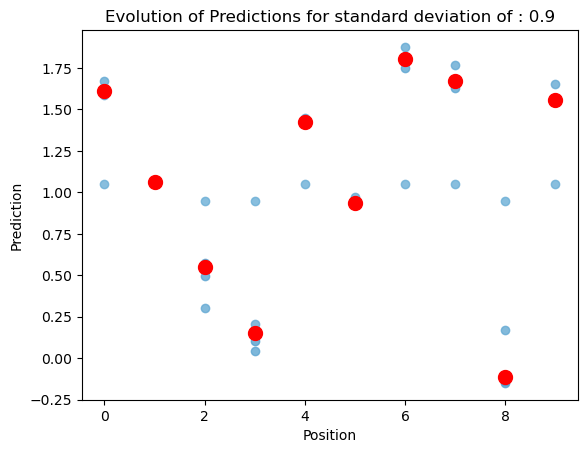

In [115]:
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))

# Plot each prediction array
for i, prediction in enumerate(pred_list):
    plt.scatter(range(len(prediction)), prediction, color=colors[i], alpha=0.8)
    

# Plot each float in pred_array
plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)

# Set axis labels and title
plt.xlabel('Position')
plt.ylabel('Prediction')
plt.title('Evolution of Predictions for standard deviation of : ' + stddev)

# Show the plot
plt.show()

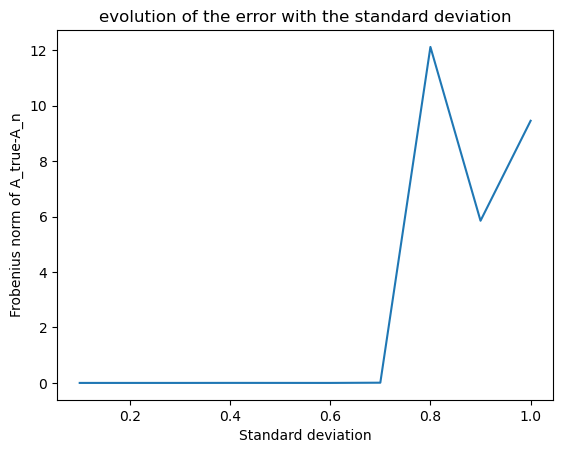

In [210]:
import matplotlib.pyplot as plt

frob_losses_500=frob_losses
keys = [float(k) for k in frob_losses.keys()]
values = list(frob_losses.values())

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()

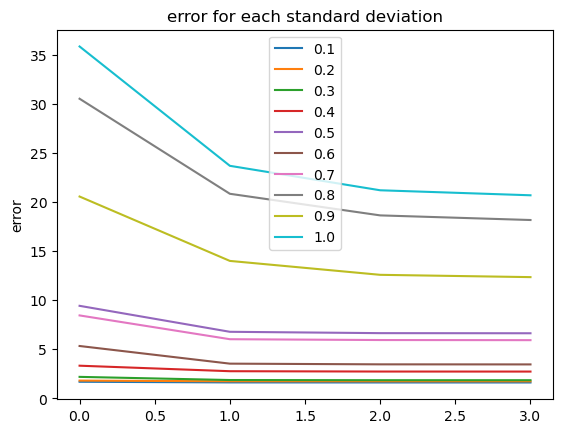

In [209]:
for key, values in training_losses.items():
    plt.plot(values[:4], label=key)

plt.title('error for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()